# SIS Model with no demographics

Moving on from the SI model to something slighlty more complex, we will add a state transition from infected back to susceptible, with no period of immunity - this is the SIS model.  It turns out that the equations governing this will be analogous to the SI model with demography - rather than births & mortality providing routes to add susceptibles and subtract infectives, this transition from infective -> susceptible will provide essentially the same mechanism. 

$$
\dot{S} = -\frac{\beta*S*I}{N} + \gamma I\\

\dot{I} = \frac{\beta*S*I}{N} - \gamma I
$$

As before, subbing $S = N-I$ into the second equation gives us

$$ \dot{I} = \beta I ( 1-\frac{\gamma}{\beta}-\frac{I}{N})$$

And comparing against the SI model with births, it is clear this equation is of the same form, with solution
$$
\frac{Nx}{1+(\frac{Nx}{I_0}-1)e^{-\beta x t}} \\
x = (1-\frac{\gamma}{\beta})
$$


This notebook tests the implementation and behavior of the model as follows:
### Contruct the model
In the first few cells, we do all the necessary imports.  Then we construct a single-patch LASER model with three components: `Susceptibility`, `Transmission`, and `Infection_SIS` - this compenent will require a new agent property `itimer`, and upon expiration of `itimer` agents will return to the susceptible state.  Finally, we initialize with a single infection and run.  The `Susceptibility` and `Transmission` components are previously described. 


### Sanity check
The first test ensures certain basic constraints are being obeyed by the model.  We confirm that at each timestep, $S_t=N_t-I_t$. 

### Scientific test
Finally, we come to the scientific test.  As before, we first test on a single instance of the model and show that the expected output is recovered.  Then, we select a few values of $\beta$ and $\gamma$, run the model, fit the outputs to the logistic equation, and compare the fitted value of $\beta$ and $\gamma$ to the known values; all of the considerations noted in the SI with births model, in terms of how to approach this fit, are echoed again here.  Of particular concern is the approximation of an exponential transition from infected back to susceptible - as we are doing a first-order finite timestep integration here, that approximation will probably produce an error linear in $\gamma \Delta t$ between the analytic result and the modeled result.  In fact, in a lot of real disease models, we have compartment dwell times in the exposed and infective states that are only a handful of $\Delta t$ long, but when doing real epi modeling and calibrating model parameters to uncertain data, this is generally not likely to be a dominant source of bias, uncertainty, etc.  But when comparing specifically against an analytic result, it can become significant.  



In [1]:
import numpy as np
import pandas as pd
from laser_core.propertyset import PropertySet
from scipy.optimize import curve_fit

from laser_generic import Model
from laser_generic.infection import Infection_SIS
from laser_generic.susceptibility import Susceptibility
from laser_generic.transmission import Transmission
import matplotlib.pyplot as plt

f"{np.__version__=}"

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


"np.__version__='1.26.4'"

In [85]:
pop = 3e5

scenario = pd.DataFrame(data=[["homenode", pop]], columns=["name", "population"])
parameters = PropertySet({"seed": 4, "nticks": 3000, "verbose": True, "beta": 1.0, "inf_mean": 3})
model = Model(scenario, parameters)
model.components = [
    Infection_SIS,
    Susceptibility,
    Transmission,
]

2025-01-06 14:14:18.810675: Creating the generic model…
Initializing the generic model with 1 patches…


In [86]:
from laser_generic.utils import seed_infections_randomly

seed_infections_randomly(model, ninfections=1)
model.run()

2025-01-06 14:14:19.755256: Running the generic model for 3000 ticks…


100%|██████████| 3000/3000 [00:09<00:00, 316.75it/s]

Completed the generic model at 2025-01-06 14:14:29.229001…
Model         :        16,428 µs
Infection_SIS :     1,622,852 µs
Susceptibility:        97,897 µs
Transmission  :     7,653,761 µs
Total:              9,390,938 microseconds


# Sanity checks
Check that the relationships between susceptible, infected, and total population hold.

S = N-I:  True


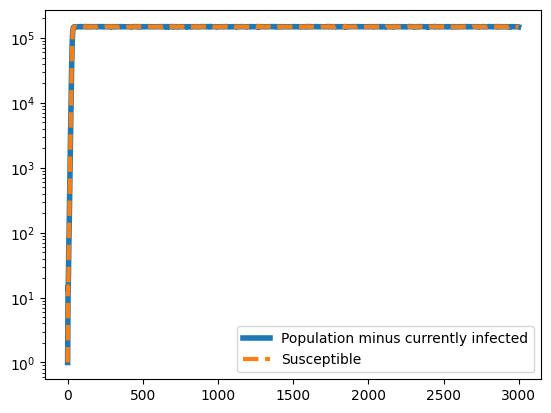

In [87]:
#I = model.patches.cases.astype("int")
#I2 = model.patches.populations[:-1] - model.patches.susceptibility.astype("int")
#plt.plot(I - I2)
plt.plot(model.patches.cases.astype("int"), lw=4)
plt.plot(model.patches.populations[:-1] - model.patches.susceptibility.astype("int"), "--", lw=3)
plt.yscale("log")
plt.legend(["Population minus currently infected", "Susceptible", "Population minus cumulative infections (incidence)"])
print('S = N-I:  '+str(np.isclose(model.patches.susceptibility, model.patches.populations[:-1] - model.patches.cases).all()))

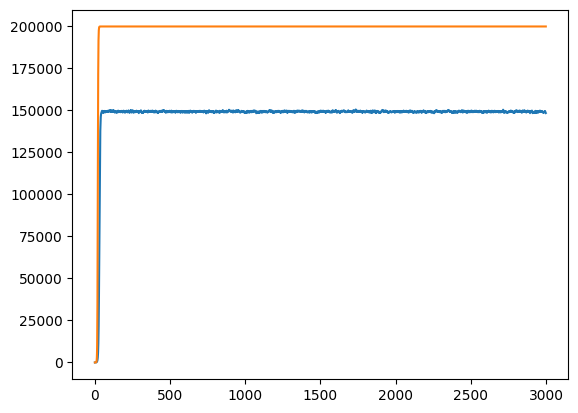

In [88]:
# def SI_logistic(t, beta, popsize, infmean, t0):
#     x = 1 - 1 / beta / infmean
#     return popsize * x / (1 + (popsize * x - 1) * np.exp(-beta * x * (t - t0)))

# t = np.arange(model.params.nticks)

# def objective(t0):
#     return np.sum((1 - SI_logistic(t, model.params.beta, pop, model.params.cbr, t0)/np.squeeze(model.patches.cases.astype("int")))**2)

# result = minimize(objective, x0=10)
# t0_opt = result.x[0]

# plt.plot(model.patches.cases, lw=4)
# plt.plot(SI_logistic(t, model.params.beta, pop, model.params.cbr, 0), lw=3)
# plt.plot(SI_logistic(t, model.params.beta, pop, model.params.cbr, t0_opt), 'r:', lw=3)
# plt.yscale("log")
# plt.legend(["Model output", "Logistic growth with known inputs, t0=0", "Logistic growth with known inputs, best-fit t0 = {:.1f}".format(t0_opt)])
# plt.ylim(9.8e5, 1e6)  


plt.plot(model.patches.cases)# + model.patches.incidence, lw=4) 

x = 1 - 1 / model.params["beta"] / model.params["inf_mean"]
t = np.arange(0, model.params["nticks"])
plt.plot(t, scenario["population"][0] * x / (1 + (scenario["population"][0] * x - 1) * np.exp(-model.params["beta"] * x * (t - 1))))
#plt.ylim(, 3e5)

In [5]:
print(1 - 1 / model.params["beta"] / model.params["inf_mean"])
print(np.mean(model.patches.cases[-100:]) / scenario["population"][0])

0.5
0.48378699999999997


2024-12-09 21:24:14.052491: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-09 21:24:14.055266: Running the generic model for 730 ticks…


100%|██████████| 730/730 [00:00<00:00, 1067.16it/s]

Completed the generic model at 2024-12-09 21:24:14.743420…
Model        :         2,431 µs
Infection_SIS:       148,221 µs
Transmission :       520,305 µs
Total:               670,957 microseconds
2024-12-09 21:24:14.752952: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-09 21:24:14.755986: Running the generic model for 730 ticks…



/tmp/ipykernel_12446/129482031.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output = pd.concat(
100%|██████████| 730/730 [00:00<00:00, 1211.32it/s]

Completed the generic model at 2024-12-09 21:24:15.361583…
Model        :         2,364 µs
Infection_SIS:       176,318 µs
Transmission :       412,537 µs
Total:               591,219 microseconds
2024-12-09 21:24:15.372245: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-09 21:24:15.374864: Running the generic model for 730 ticks…



100%|██████████| 730/730 [00:00<00:00, 1548.49it/s]

Completed the generic model at 2024-12-09 21:24:15.849730…
Model        :         2,240 µs
Infection_SIS:       121,038 µs
Transmission :       339,764 µs
Total:               463,042 microseconds
2024-12-09 21:24:15.860532: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-09 21:24:15.863165: Running the generic model for 730 ticks…



100%|██████████| 730/730 [00:00<00:00, 1362.57it/s]

Completed the generic model at 2024-12-09 21:24:16.402245…
Model        :         2,226 µs
Infection_SIS:       109,680 µs
Transmission :       415,992 µs
Total:               527,898 microseconds
2024-12-09 21:24:16.411362: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-09 21:24:16.414477: Running the generic model for 730 ticks…



100%|██████████| 730/730 [00:00<00:00, 1359.44it/s]

Completed the generic model at 2024-12-09 21:24:16.955383…
Model        :         2,456 µs
Infection_SIS:       125,617 µs
Transmission :       398,471 µs
Total:               526,544 microseconds
2024-12-09 21:24:16.965879: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-09 21:24:16.969033: Running the generic model for 730 ticks…



100%|██████████| 730/730 [00:00<00:00, 1936.36it/s]

Completed the generic model at 2024-12-09 21:24:17.349364…
Model        :         2,525 µs
Infection_SIS:        82,860 µs
Transmission :       283,179 µs
Total:               368,564 microseconds
2024-12-09 21:24:17.359238: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-09 21:24:17.362870: Running the generic model for 730 ticks…



100%|██████████| 730/730 [00:00<00:00, 1829.30it/s]


Completed the generic model at 2024-12-09 21:24:17.765580…
Model        :         2,218 µs
Infection_SIS:        88,905 µs
Transmission :       300,592 µs
Total:               391,715 microseconds
2024-12-09 21:24:17.778714: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-09 21:24:17.780471: Running the generic model for 730 ticks…


100%|██████████| 730/730 [00:00<00:00, 1276.40it/s]

Completed the generic model at 2024-12-09 21:24:18.354655…
Model        :         2,231 µs
Infection_SIS:       169,079 µs
Transmission :       391,882 µs
Total:               563,192 microseconds
2024-12-09 21:24:18.370009: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-09 21:24:18.371910: Running the generic model for 730 ticks…



100%|██████████| 730/730 [00:00<00:00, 1550.08it/s]

Completed the generic model at 2024-12-09 21:24:18.845945…
Model        :         2,671 µs
Infection_SIS:       112,770 µs
Transmission :       346,124 µs
Total:               461,565 microseconds
2024-12-09 21:24:18.856358: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-09 21:24:18.858748: Running the generic model for 730 ticks…



100%|██████████| 730/730 [00:00<00:00, 1690.36it/s]

Completed the generic model at 2024-12-09 21:24:19.294358…
Model        :         2,269 µs
Infection_SIS:        95,984 µs
Transmission :       324,557 µs
Total:               422,810 microseconds


(-50.0, 50.0)

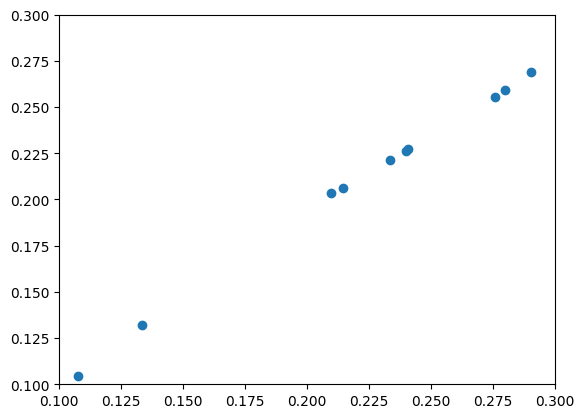

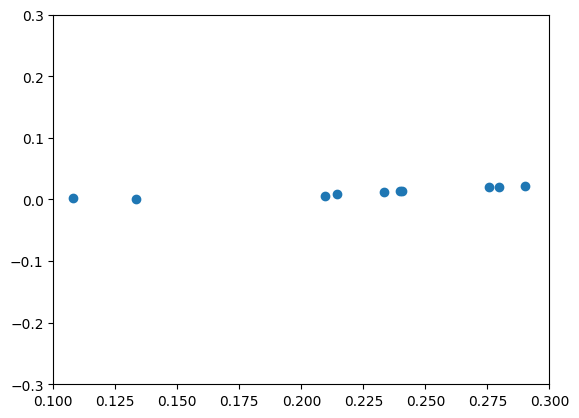

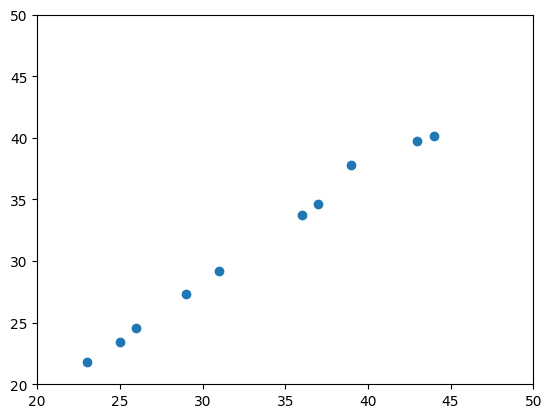

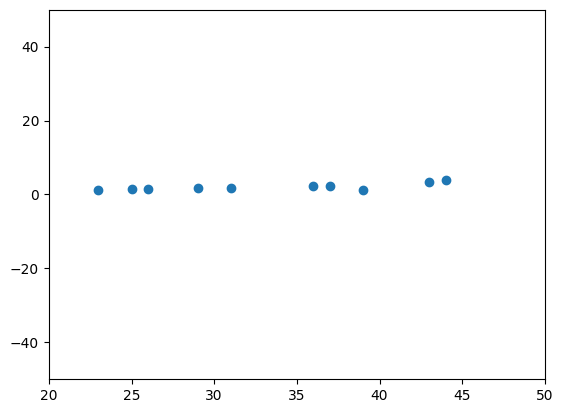

In [9]:
# Need to rethink this - the fit is degenerate in size, mu, gamma all together, so fix population size for now.
# Better solution is to use functools partial, keep size as a parameter, and then fix it later using the actual scenario population.
# But this is a quick test, meant to inform a better approach by somebody down the line to formalize it.
def SIS_logistic(t, beta, gamma, t0):
    x = 1 - (1 / gamma / beta)
    return 1e5 * x / (1 + (1e5 / 10 * x - 1) * np.exp(-beta * x * (t - t0)))


nticks = 730
t = np.arange(730)
betarange = [0.1, 0.3]
gammarange = [20, 50]
seeds = [i for i in range(10)]
betas = np.random.uniform(betarange[0], betarange[1], 10)
gammas = np.random.randint(gammarange[0], gammarange[1], 10)
output = pd.DataFrame(columns=["seed", "beta", "gamma", "cases", "fitted_beta", "fitted_gamma", "fitted_t0"])
scenario = pd.DataFrame(data=[["homenode", 1e5, "47°36′35″N 122°19′59″W"]], columns=["name", "population", "location"])

for seed, beta, gamma in zip(seeds, betas, gammas):
    parameters = PropertySet({"seed": seed, "nticks": nticks, "verbose": True, "beta": beta, "inf_mean": gamma})
    model = Model(scenario, parameters)
    model.components = [
        Susceptibility,
        Infection_SIS,
        Transmission,
    ]
    seed_infections_randomly(model, ninfections=10)
    model.run()
    cases = [model.patches.cases[i][0] for i in range(nticks)]
    try:
        popt, pcov = curve_fit(
            SIS_logistic,
            t,
            cases,
            p0=[0.05, 40, 1],
            bounds=([betarange[0] / 2, gammarange[0] / 2, 1], [betarange[1] * 2, gammarange[1] * 2, 365]),
        )
    except:
        popt = [0, 0, 0, 0]
    output = pd.concat(
        [
            output,
            pd.DataFrame.from_dict(
                {
                    "seed": seed,
                    "beta": beta,
                    "gamma": gamma,
                    "cases": [np.array(cases)],
                    "fitted_beta": popt[0],
                    "fitted_gamma": popt[1],
                    "fitted_t0": popt[2],
                }
            ),
        ],
        ignore_index=True,
    )

plt.figure()
plt.plot(output["beta"], output["fitted_beta"], "o")
plt.xlim(betarange[0], betarange[1])
plt.ylim(betarange[0], betarange[1])
plt.figure()
plt.plot(output["beta"], output["beta"] - output["fitted_beta"], "o")
plt.xlim(betarange[0], betarange[1])
plt.ylim(-betarange[1], betarange[1])
plt.figure()
plt.plot(output["gamma"], output["fitted_gamma"], "o")
plt.xlim(gammarange[0], gammarange[1])
plt.ylim(gammarange[0], gammarange[1])
plt.figure()
plt.plot(output["gamma"], output["gamma"] - output["fitted_gamma"], "o")
plt.xlim(gammarange[0], gammarange[1])
plt.ylim(-gammarange[1], gammarange[1])

In [10]:
output

,seed,beta,gamma,cases,fitted_beta,fitted_gamma,fitted_t0
0,0,0.133355,23,"[10, 12, 14, 15, 17, 18, 22, 23, 27, 28, 31, 3...",0.132069,21.771532,1.000000
1,1,0.275712,31,"[9, 12, 16, 22, 34, 40, 46, 55, 71, 80, 108, 1...",0.255529,29.218645,1.037198
2,2,0.290193,25,"[9, 11, 16, 23, 32, 38, 45, 49, 57, 72, 94, 11...",0.268926,23.454394,1.075280
3,3,0.107750,39,"[10, 9, 10, 12, 11, 12, 13, 14, 13, 12, 13, 15...",0.104620,37.800143,8.767956
4,4,0.239821,26,"[9, 10, 15, 21, 30, 34, 39, 45, 49, 61, 68, 82...",0.226278,24.552481,1.000000
5,5,0.214552,43,"[10, 15, 20, 23, 28, 32, 38, 47, 50, 60, 73, 8...",0.206088,39.757006,1.000000
6,6,0.279601,29,"[9, 15, 19, 23, 26, 36, 44, 58, 68, 76, 94, 11...",0.259199,27.309203,1.758045
7,7,0.233380,36,"[10, 14, 18, 21, 23, 32, 41, 51, 64, 78, 92, 1...",0.221097,33.766887,1.000000
8,8,0.209568,44,"[9, 12, 14, 15, 18, 22, 35, 39, 45, 60, 73, 87...",0.203577,40.178897,1.000000
9,9,0.240485,37,"[9, 12, 14, 14, 16, 17, 23, 31, 39, 47, 55, 70...",0.227433,34.615325,1.632118


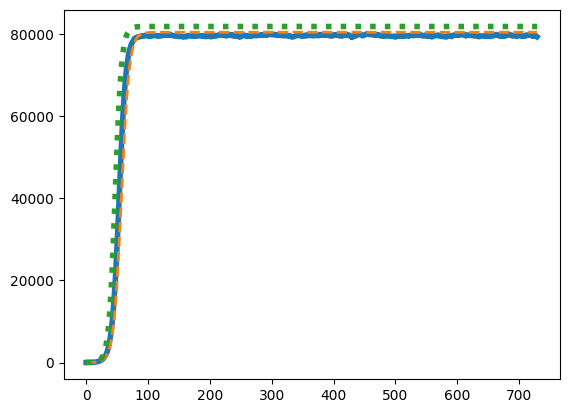

In [8]:
ind = 3
plt.plot(t, output["cases"].iloc[ind], "-", lw=4)
t = np.arange(730)
plt.plot(SIS_logistic(t, output["fitted_beta"].iloc[ind], output["fitted_gamma"].iloc[ind], output["fitted_t0"].iloc[ind]), "--", lw=2)
plt.plot(SIS_logistic(t, output["beta"].iloc[ind], output["gamma"].iloc[ind], 1), ":", lw=4)

1

In [19]:
1 / 95 / 365 / 0.04

(array([140., 125.,  85.,  88.,  93.,  51.,  56.,  47.,  62.,  44.,  33.,
         24.,  28.,  24.,  24.,  18.,  17.,  10.,  13.,  18.]),
 array([  0.  ,  12.75,  25.5 ,  38.25,  51.  ,  63.75,  76.5 ,  89.25,
        102.  , 114.75, 127.5 , 140.25, 153.  , 165.75, 178.5 , 191.25,
        204.  , 216.75, 229.5 , 242.25, 255.  ]),
 <BarContainer object of 20 artists>)

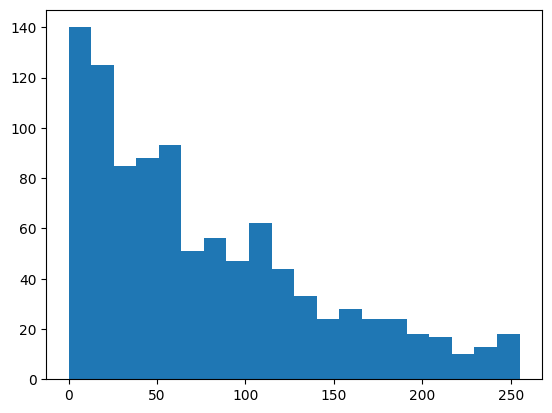